# Feed Forward Neural Network
In this tutorial, we are going to implement a neural network with fully-connected layers to perform classification, and test it out on the MNIST dataset.

## Import library and load MNIST dataset
MNIST dataset has 55,000 examples for training and 10,000 examples for testing. Each image has a size of 784 (28x28). 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


mnist = input_data.read_data_sets("./mnist", one_hot=True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

print "x_train: ", x_train.shape
print "y_train: ", y_train.shape
print "x_test: ", x_test.shape
print "y_test: ", y_test.shape

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
x_train:  (55000, 784)
y_train:  (55000, 10)
x_test:  (10000, 784)
y_test:  (10000, 10)


## Data sanity check
Before implementing a neural network, we will check whether we load the correct MNIST dataset.

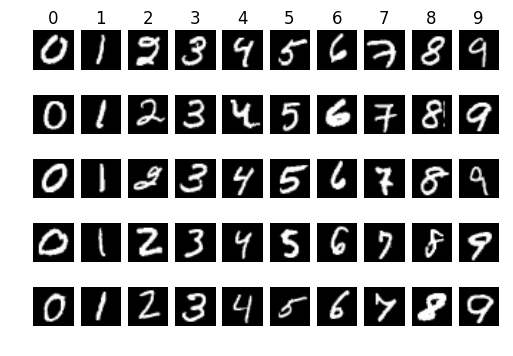

In [2]:
def plot_mnist(data, classes, incorrect=None):
    
    for i in range(10):
        idxs = (classes == i)
        
        # for test: see last part of this ipython notbook file
        if incorrect is not None:
            idxs *= incorrect
        # get 10 images for class i
        images = data[idxs][0:10]
        
        num_plot = 5
        for j in range(num_plot):   
            plt.subplot(num_plot, 10, i + j*10 + 1)
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # print a title only once for each class
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

classes = np.argmax(y_train, 1)
plot_mnist(x_train, classes)

## Fully-connected layer
To implement a fully-connected layer, we can simply use [tf.matmul](https://www.tensorflow.org/versions/r0.11/api_docs/python/math_ops.html#matmul) function for 2D matrix multiplication. In this code, we are using [tf.variable_scope](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#variable_scope) and [tf.get_variable](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#get_variable) functions to encapsulate and manage tensor variables effectively. Also, We are choosing a [tf.random_uniform_initializer](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#random_uniform_initializer) as variable initializer for our model. There are some other variable initializers such as [tf.random_normal_initializer](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#random_normal_initializer) and [tf.truncated_normal_initializer](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#truncated_normal_initializer). 

In [3]:
def fully_connected(x, dim_in, dim_out, name):
    with tf.variable_scope(name) as scope:
        # create variables
        w = tf.get_variable('w', shape=[dim_in, dim_out], 
                            initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
        b = tf.get_variable('b', shape=[dim_out])
        
        # create operations
        out = tf.matmul(x, w) + b
        
        return out    

## Neural network
Now, we will develope a neural network with 2 hidden layers using a `fully_connected` function. In this code, we are using a [tf.nn.relu](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#relu) as our non-linear activation function. There are some other non-linearities such as [tf.nn.tanh](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#tanh) and [tf.nn.sigmoid](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#sigmoid).

In [4]:
# Create model
def neural_network(x, dim_in=784, dim_h=500, dim_out=10):
    # 1st hidden layer with ReLU
    h1 = fully_connected(x, dim_in, dim_h, name='h1')
    h1 = tf.nn.relu(h1)
    
    # 2nd hidden layer with ReLU
    h2 = fully_connected(h1, dim_h, dim_h, name='h2')
    h2 = tf.nn.relu(h2)
    
    # output layer with linear
    out = fully_connected(h2, dim_h, dim_out, name='out')
    
    return out

## Place holder
To train the neural network with mini-batch gradient descent, placeholders should be defined for mini-batch input data and target data. In addition, None type is used so that any batch size of data can be fed into the placeholder.

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

## Construct graph
Now, we will build a graph for our neural network. Note that you should run the cell below only once. If you run this more than once, an error message will be printed out: `"ValueError: Variable h1/w already exists, disallowed."`. This is because we used `tf.get_variable` above and this function doesn't allow creating variables with the existing names. 
To fix this problem, you can just type [tf.get_variable_scope().reuse_variables()](https://www.tensorflow.org/versions/r0.11/how_tos/variable_scope/index.html) before cell below and run it. Then, `tf.get_variable`  will use previously created tensor variables instead of trying to create new ones.

In [6]:
# Construct model with default value
out = neural_network(x)

## Loss and optimizer
To train the neural network, we should implement loss (this is a tensor) and optimizer (this is an operator). We can use [tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#softmax_cross_entropy_with_logits) function to compute the loss. This function expects unscaled logits, since it performs a softmax on logits internally for efficiency. Do not call this op with the output of softmax, as it will produce incorrect results.
Also, we choose [tf.train.RMSPropOptimizer](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#RMSPropOptimizer) as our optimizer to minimize the loss. If you want to see other optimizers such as [tf.train.AdamOptimizer](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#AdamOptimizer), please see [here](https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#GradientDescentOptimizer).

In [7]:
# loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss)

# Test model
pred = tf.argmax(out, 1)
target = tf.argmax(y, 1)

correct_pred = tf.equal(pred, target)
incorrect_pred = tf.not_equal(pred, target)
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Session: train and test model
From above, we build our neural network model to classify the MNIST dataset. To launch our model, we will implement a session where the model is actually trained and tested on the MNIST dataset.

** Train **

First, we initialize all variables we created above. 
This can be done by running [tf.initialize_all_variables()](https://www.tensorflow.org/versions/r0.11/api_docs/python/state_ops.html#initialize_all_variables). All variables in the default graph are initialized with `tf.random_uniform_initializer` in our case.
The most important part of code in the training phase is `sess.run([optimizer, loss], feed_dict={x: x_batch, y:y_batch})`. This part of code feeds mini-batch data into placeholder and run optimizer to update variables with `tf.train.RMSPropOptimizer` once. 
Also, loss is evaluated to print out the average loss for each epoch.

** Test **

Testing phase is quite simple. We use `sess.run(accuracy, {x: mnist.test.images, y: mnist.test.labels})` to print out the test accuracy. 
Also, `sess.run([pred, incorrect_pred], {x: mnist.test.images, y: mnist.test.labels})` is used to get predictions and incorrectly predicted indices of our model on MNIST dataset.
`p` and `incorrect` are used to visualize the model's incorrect prediction on MNIST dataset.

Epoch 1, Loss: 0.597
Epoch 2, Loss: 0.111
Epoch 3, Loss: 0.066
Epoch 4, Loss: 0.045
Epoch 5, Loss: 0.034
Epoch 6, Loss: 0.024
Epoch 7, Loss: 0.018
Epoch 8, Loss: 0.015
Epoch 9, Loss: 0.013
Epoch 10, Loss: 0.011
Finished training!

Test accuracy: 0.979
Incorrect Case


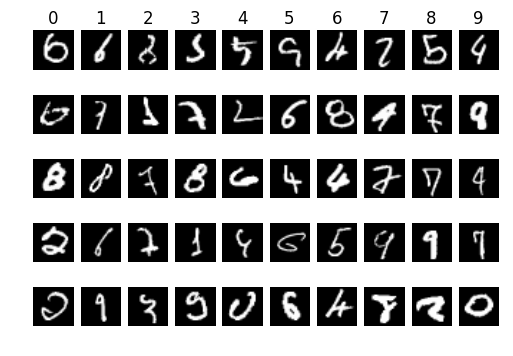

In [8]:
batch_size = 100
num_epochs = 10

# launch the graph
with tf.Session() as sess:
    # initialize tensor variables
    tf.initialize_all_variables().run()
    # training cycle
    for epoch in range(num_epochs):
        avg_loss = 0.
        n_iters_per_epoch = int(mnist.train.num_examples / batch_size)
        # loop over all batches
        for i in range(n_iters_per_epoch):
            x_batch, y_batch = mnist.train.next_batch(batch_size)
            # run optimization op (backprop) and loss op (to get loss value)
            _, c = sess.run([optimizer, loss], feed_dict={x: x_batch, y: y_batch})
            # compute average loss
            avg_loss += c / n_iters_per_epoch
        print "Epoch %d, Loss: %.3f"% (epoch+1, avg_loss)
    print "Finished training!"
    
    print ""
    print "Test accuracy:", sess.run(accuracy, {x: mnist.test.images, y: mnist.test.labels})
    p, incorrect = sess.run([pred, incorrect_pred], {x: mnist.test.images, y: mnist.test.labels})
    
    print "Incorrect Case"
    plot_mnist(x_test, classes=p, incorrect=incorrect)